# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [1]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos'
VIDEO_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos/231212_Gandalf'
file_container_obj = FileContainer(ROOT_DIR, VIDEO_DIR)

Session folder not found.
  Select .h5 behavior file (i.e. None_None_choice.h5)
  Select directory containing White Matter video files (i.e. None_None)
  Select directory containing SpikeGLX files (i.e. None_None_g0)
Behavior file selected: C:/Users/rober/SynologyDrive/Rahim/aragorn_20240110/240110_Aragorn_generalization.h5
  MonkeyLogic Date: 240110
  MonkeyLogic Monkey: aragorn
Video files directory selected: C:/Users/rober/Desktop/rhAirpuff/videos/240110_Aragorn
  White Matter Video Date: 240110
  White Matter Video Monkey: aragorn
SpikeGLX files directory selected: C:/Users/rober/SynologyDrive/Rahim/aragorn_20240110/aragorn_20240110_g1
  SpikeGLX Date: 240110
  SpikeGLX Monkey: aragorn



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [2]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 587
  Choice task detected.
Parsing session data...


  0%|          | 0/587 [00:00<?, ?it/s]

  Complete.
    Correct trials: 395
    Errored trials: 192
    Session Length:  02:09:54
Creating Session Objects...
Lick threshold: 2.24 mV
  Min Values (X,Y): (-124.7,-69.867)
  Max Values (X,Y): (106.223,123.136)
  Reward Mag: 1.0
    Reward Drops: 12.0
    Reward Frequency: 1.0
    Reward Length: 220.0
  Reward Mag: 0.5
    Reward Drops: 4.0
    Reward Frequency: 1.0
    Reward Length: 200.0
  Reward Mag: 0.0
    Reward Drops: 0.0
    Reward Frequency: 0.0
    Reward Length: 0.0
  Airpuff Mag: 1.0
    Airpuff Magnitude: 1.0
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.5
    Airpuff Magnitude: 0.5
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.0
    Airpuff Magnitude: 0.0
    Airpuff Frequency: 0.0
Adding additional fields to session_df DataFrame...


c:\Users\rober\Desktop\Monkey-Emotions\config\add_fields.py:335: RuntimeWarning: Mean of empty slice
  lick_avg = np.nanmean(lick_in_window)


  ['cam_frames'] field added.
  20 new fields added.
	0 rows removed due to nan valence.


In [3]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

In [4]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,stimuli_name_0,x_0_pos,y_0_pos,stimuli_name_1,x_1_pos,y_1_pos,stimuli_name_2,x_2_pos,y_2_pos,reward_1,reward_prob_1,reward_mag_1,reward_drops_1,reward_length_1,reward_2,reward_prob_2,reward_mag_2,airpuff_1,airpuff_prob_1,airpuff_mag_1,airpuff_2,airpuff_prob_2,airpuff_mag_2,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,reinforcement_trial,choice_trial,stim_chosen,stim_2_chosen,fractal_chosen,reward,reward_mag,airpuff,airpuff_mag,Start Trial,Fixation On,Fixation Success,CS On,Fixation Off,Trace Start,Trace End,Outcome Start,Reward Trigger,Airpuff Trigger,Outcome,Outcome End,Manual Reward,End Trial,valence,valence_1,valence_2,valence_not_chosen,lick_raster,DEM_raster,trial_bins,trial_in_block,lick_count_window,blink_count_window,pupil_data_window,pupil_raster,pupil_raster_window,pupil_raster_window_avg,pupil_binary_zero,blink_onset,blink_offset,blink_raster,blink_raster_window,blink_duration_window,pupil_pre_CS,lick_in_window,blink_in_window,lick_duration,blink_duration_sig,blink_duration_offscreen,eye_distance,cam_frames,fractal_count_in_block
0,240110,0,aragorn,1,1,1,0,1,1,"[9, 100, 101, 113, 113, 113, 113, 113, 113, 11...","[2.810800011502579, 2662.726800015662, 2738.25...",_fix,[0.0],[0.0],_fractal_D,[0.0],[0.0],_fractal_D,[0.0],[0.0],0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0,"[106.22334748653218, 106.22334748653218, 106.2...","[123.13581380654256, 123.13581380654256, 123.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.1575138613377742, 0.17658583855084684, 0.19...","[-0.0003231997561155553, 3.465516712118176, 3....","[-0.012160979980345016, 0.15291028060078937, 0...","[0.5511199776942904, 0.7461144677822599, 0.703...",0.0000,54302.0000,2024-01-10 14:43:28.505,2024-01-10 14:44:22.807,1,0,4,0,_error,0,0.0,0,0.0,2662,2738,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13211,0.0,-1.0,0.0,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",54300,0,NaN,NaN,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,NaN,NaN,[nan],[nan],[nan],[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1342, 1351, 1359, 1367, 1376, 1384, 1392, 140...",0
1,240110,0,aragorn,2,1,1,0,1,3,"[9, 100, 101, 102, 103, 113, 18]","[1497.8883999865502, 1609.5365999790374, 1659....",_fix,[0.0],[0.0],_fractal_C,[0.0],[0.0],_fractal_C,[0.0],[0.0],0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,1.0,0.5,0,0.0,0.0,"[106.22334748653218, 106.22334748653218, 106.2...","[123.13581380654256, 123.13581380654256, 123.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.362957779853485, 2.351119994849379, 2.35276...","[3.268220019528618, 3.2721659527228524, 3.3159...","[3.2090310247209435, 3.3037334192211993, 3.288...","[0.39887300786741176, 0.5511199776942904, 0.55...",54300.5588,82056.5588,2024-01-10 14:44:22.806,2024-01-10 14:44:50.562,1,0,3,0,_error,0,0.0,0,0.0,1609,1659,25881,25912,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,27705,0.0,-0.5,0.0,-0.5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",27754,1,NaN,NaN,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,NaN,NaN,[nan],[nan],[nan],[nan],NaN,"[6198.0, 6198.0, 6187.0, 6187.0, 6191.0, 6191....",NaN,NaN,NaN,NaN,NaN,NaN,"[7, 15, 24, 32, 40, 49, 57, 65, 74, 82, 90, 99...",0
2,240110,0,aragorn,3,1,1,1,0,0,"[9, 100, 101, 102, 103, 104, 105, 106, 107, 10...","[1465.0460999982897, 1567.8781000024173, 1601....",_fix,[0.0],[0.0],_fractal_B,[0.0],[0.0],_fractal_B,[0.0],[0.0],1,1.0,0.5,4.0,200.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,"[106.22334748653218, 106.22334748653218, 106.2...","[123.13581380654256, 123.13581380654256, 123.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.870338548835441, 2.8578431014889185, 2.8759...","[-0.042741912672144805, 3.261643464262846, 3.3...","[3.2432291099024684, 

In [6]:
import pickle
from config.h5_helper import pickler

dest_path = "/Users/rahimhashim/SynologyDrive/Rob/gandalf_20231223"
dest_path = file_container_obj.ml_file_path
# dest_path = os.path.dirname(file_container_obj.ml_file_path)

pickler(True, 
        save_path=dest_path, 
        session_df=session_obj.df, 
        monkey_input='gandalf',
        experiment_name='UnityVR',
        error_dict=error_dict, 
        behavioral_code_dict=behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/SynologyDrive/Rob/gandalf_20231223
  Pickling 231223_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.8221 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [5]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\Desktop\Rob\_data\20231223_gandalf\gandalf_20231223_g0\gandalf_20231223_g0_t0.nidq.bin
File Name: D://gandalf_20231223_g0/gandalf_20231223_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-23T17:36:59
  File Length: 6040.45037399812
nChan: 9, nFileSamp: 12080867
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  1999.994413
 Channel [0]: cam_sync
  Max Val: 3345.032
  Min Val: -5.798
 Channel [1]: cam_save
  Max Val: 29.602
  Min Val: -8.24
 Channel [2]: lick
  Max Val: 8.85
  Min Val: -34.485
 Channel [3]: photodiode
  Max Val: 2215.576
  Min Val: 423.584
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


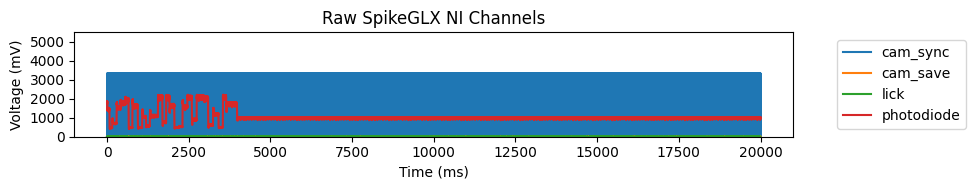

In [12]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

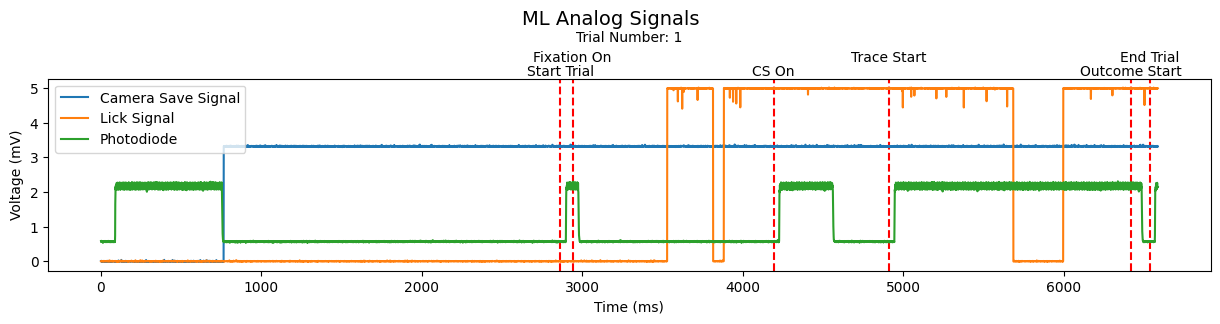

In [6]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [ ]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

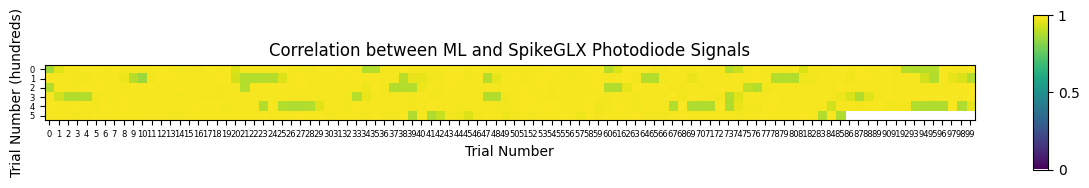

In [10]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [11]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Video Parsing Complete.
  Missing Videos: defaultdict(<class 'list'>, {'e3v831b': [0, 1, 7, 21, 22, 23, 28, 33, 34, 35, 36, 37, 39, 42, 44, 46, 60, 73, 74, 79, 91, 92, 93, 94, 95, 102, 107, 109, 110, 120, 121, 122, 123, 124, 125, 131, 138, 139, 147, 164, 165, 178, 179, 180, 186, 194, 195, 196, 197, 198, 199, 200, 206, 207, 217, 221, 222, 227, 234, 237, 238, 239, 246, 247, 249, 251, 258, 259, 260, 261, 275, 276, 277, 280, 283, 286, 291, 294, 301, 302, 303, 304, 311, 314, 315, 316, 317, 318, 321, 332, 333, 346, 347, 348, 351, 358, 368, 370, 372, 373, 378, 382, 385, 386, 387, 389, 391, 394, 404, 407, 417, 419, 423, 424, 425, 426, 427, 428, 433, 437, 438, 440, 441, 444, 449, 452, 454, 458, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 476, 478, 479, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 507, 525, 528, 530, 531, 532, 533, 534, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 552, 553, 557, 558, 564, 565, 569, 578, 579, 580, 

In [53]:
# see differences between the values of the different dictionary keys
cam_videos = [spikeglx_obj.trial_missing_videos[cam] for cam in spikeglx_obj.trial_missing_videos.keys()]
cam_videos = [item for sublist in cam_videos for item in sublist]
# sort the list
cam_videos.sort()
for cam in set(cam_videos):
  # count the number of times each video appears in the list
  if cam_videos.count(cam) != len(spikeglx_obj.trial_missing_videos.keys()):
    print(cam, cam_videos.count(cam))

247 3


***
## DeepLabCut Pretrained Pose-Assignment

### Manually Assign Cameras

Based on your WhiteMatter camera setup, assign the identifying code of the camera (e3vXXXX) with what it is pointing to in this dictionary. Depending on whether you set the key have `face` or `body` will drive which DLC pretrained model you end up using (`primate_face` vs. `full_macaque`).

In [12]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [13]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Monkey-Emotions\video\aragorn_240110
  Number of videos found: 1577


  0%|          | 0/1577 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 394
  Camera: e3v8360 | Number of videos: 394
  Camera: e3v83ad | Number of videos: 395
  Camera: e3v83d6 | Number of videos: 394


In [14]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\aragorn_240110\\aragorn_240110_100_e3v831b.mp4']
Created "240110_aragorn\body_2-rh-2024-01-11\videos"
Created "240110_aragorn\body_2-rh-2024-01-11\labeled-data"
Created "240110_aragorn\body_2-rh-2024-01-11\training-datasets"
Created "240110_aragorn\body_2-rh-2024-01-11\dlc-models"
Copying the videos
240110_aragorn\body_2-rh-2024-01-11\videos\aragorn_240110_100_e3v831b.mp4
Generated "240110_aragorn\body_2-rh-2024-01-11\config.yaml"

A new project with name body_2-rh-2024-01-11 is created at 240110_aragorn and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' to select frames

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_2-rh-2024-01-11\dlc-models\iteration-0\body_2Jan11-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


240110_aragorn\body_2-rh-2024-01-11\dlc-models\iteration-0\body_2Jan11-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 240110_aragorn\body_2-rh-2024-01-11\dlc-models\iteration-0\body_2Jan11-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  240110_aragorn\body_2-rh-2024-01-11\videos\aragorn_240110_100_e3v831b.mp4
Loading  240110_aragorn\body_2-rh-2024-01-11\videos\aragorn_240110_100_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:08<00:00, 20.10it/s] 


Saving results in 240110_aragorn\body_2-rh-2024-01-11\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\aragorn_240110\\aragorn_240110_100_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\training-datasets"

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\dlc-models\iteration-0\face_1Jan11-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\dlc-models\iteration-0\face_1Jan11-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\dlc-models\iteration-0\face_1Jan11-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\videos\aragorn_240110_100_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\videos\aragorn_240110_100_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:04<00:00, 36.93it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_1-rh-2024-01-11\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\aragorn_240110\\aragorn_240110_100_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-E

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\dlc-models\iteration-0\body_1Jan11-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\dlc-models\iteration-0\body_1Jan11-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\dlc-models\iteration-0\body_1Jan11-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\videos\aragorn_240110_100_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\videos\aragorn_240110_100_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.82it/s] 


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\body_1-rh-2024-01-11\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\aragorn_240110\\aragorn_240110_100_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\dlc-models\iteration-0\face_2Jan11-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\dlc-models\iteration-0\face_2Jan11-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\dlc-models\iteration-0\face_2Jan11-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\videos\aragorn_240110_100_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\videos\aragorn_240110_100_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 77.73it/s] 


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\240110_aragorn\face_2-rh-2024-01-11\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [24]:
# # deeplabcut.refine_labels(config_path_dict['e3v8360'])
# deeplabcut.extract_frames(config_path_dict['e3v8360'], 'automatic')

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: C:\Users\rober\Desktop\Monkey-Emotions\231212_aragorn\face_1-rh-2024-01-08\videos\aragorn_231212_0_e3v8360.mp4 ?
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1.51  seconds.
Extracting and downsampling... 181  frames from the video.


181it [00:00, 350.18it/s]


Kmeans clustering ... (this might take a while)


### Evaluate Network

TRY THIS TODAY
https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/generate_training_dataset/frame_extraction.py

In [ ]:
# deeplabcut.evaluate_network(config_path_dict['e3v8360'], 
#                      dlc_video_path_dict['video_path_dict'], 
#                      plotting=True)
# deeplabcut.extract_frames(
#           config_path_dict['e3v8360'],
#           'automatic',
#           'kmeans',
#           'GUI',
#         )

### Run Full Model

In [ ]:
# Run DLC
dlc_config.dlc_run(config_path_dict, 
                   dlc_video_path_dict, 
                   start_video=0, 
                   end_video=None, 
                   videotype='mp4', 
                   create_labeled_video=False)

In [60]:
# count number of videos in output directory
print('Number of videos in output directory:')
for cam in dlc_video_path_dict.keys():
  print(f'  {cam}: {len(dlc_video_path_dict[cam])}')
print('Number of videos expected:')
print(f' Correct trials: {len(session_obj.df[session_obj.df["correct"] == 1])}')
print(f' Total trials:   {len(session_obj.df)}')

Number of videos in output directory:
  e3v831b: 394       
  e3v8360: 394       
  e3v83ad: 395       
  e3v83d6: 394       
Number of videos expected:
 Correct trials: 395 
 Total trials:   587


***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()